In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from copy import deepcopy
from enum import Enum
from contextlib import contextmanager
from typing import Any, Optional, Tuple, Union, Callable
from torch import Tensor


from gpytorch.kernels import MaternKernel
from botorch.sampling.pathwise import draw_matheron_paths
from botorch.models import SingleTaskGP
from botorch.test_functions import Hartmann, Branin

from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy.special import digamma
from scipy.spatial.distance import pdist, squareform

@contextmanager
def torch_random_seed(
        seed: int,
):
    """
    Sets the random seed for torch operations within the context.

    Parameters:
    seed (int): The random seed to be set.

    This function sets the random seed for torch operations within the context. After the context is exited, the random
    seed is reset to its original value.
    """
    torch_state = torch.random.get_rng_state()
    torch.manual_seed(seed)
    try:
        yield
    finally:
        torch.random.set_rng_state(torch_state)


def knn_entropy(X, k=3):
    """
    Estimate the Shannon entropy of a dataset using the k-nearest neighbors method.
    
    Parameters:
        X (numpy.ndarray): The N x D array of data points.
        k (int): Number of neighbors to use in the k-NN estimation.
        
    Returns:
        float: The estimated entropy.
    """
    N, D = X.shape
    tree = cKDTree(X)
    distances, _ = tree.query(X, k + 1)  # k+1 because the point itself is included in neighbors
    nn_distances = distances[:, -1]  # k-th nearest neighbor distance
    avg_log_dist = np.mean(np.log(nn_distances + 1e-10))  # Add small value to avoid log(0)
    
    # Calculate the entropy
    entropy_estimate = (
        digamma(N) - digamma(k) + D * np.log(2) + D * avg_log_dist
    )
    return entropy_estimate

def exploration_entropy(X):
    """
    Calculate the empirical Shannon entropy over cumulative observation points at each time step,
    dynamically setting k based on the sample size.
    
    Parameters:
        X (numpy.ndarray): The T x D array where each row is a data point in [0, 1]^D.
    
    Returns:
        numpy.ndarray: An array of entropy values for each time step.
    """
    T, D = X.shape
    entropies = np.zeros(T)
    cumulative_data = []

    for t in range(T):
        # Append the current data point to the cumulative list
        cumulative_data.append(X[t])
        cumulative_array = np.array(cumulative_data)

        # Dynamically set k as the square root of current sample size
        k = max(3, int(np.sqrt(t + 1)))  # Minimum k of 3 for stability

        # Estimate entropy using k-NN on cumulative data
        entropies[t] = knn_entropy(cumulative_array, k=k)

    return entropies[D:] # Due to singularity, the first D points are ignored

def exploration_center_movement(X):
    """
    Movement of observation center over time.
    Args:
        X (np.ndarray): shape (T, D)
    Returns:
        Z (np.ndarray): shape (T, 1)
    """
    T, D = X.shape
    prev_center = np.zeros(D)
    accu_movement = np.zeros(shape=(T, 1))
    for t in range(T):
        x = X[t]
        accu_movement[t, 0] += np.linalg.norm(x - prev_center)
        prev_center = x
    return np.cumsum(accu_movement, axis=0)

def exploration_tsp(X): 
    """
    Movement of observation center over time.
    Args:
        X (np.ndarray): shape (T, D)
    Returns:
        Z (np.ndarray): shape (T, 1)
    """
    T, D = X.shape
    tsp_solution = np.zeros(shape=(T, 1))
    
    # Initialize with the first point's TSP solution
    current_path, cumulative_distance = [0, 0], 0.0
    tsp_solution[0, 0] = cumulative_distance
    
    # Calculate distances incrementally
    for t in range(1, T):
        
        # Update path by finding the best place to insert the new point
        best_distance_increase = float('inf')
        best_insertion_index = None
        dist_matrix = squareform(pdist(X[:t+1]))  # Update distance matrix to include the new point
        
        # Try inserting the new point in each position in the current path
        for i in range(len(current_path) - 1):
            # Calculate distance if new point were inserted between path[i] and path[i+1]
            dist_increase = (dist_matrix[current_path[i], t] +
                             dist_matrix[t, current_path[i+1]] -
                             dist_matrix[current_path[i], current_path[i+1]])
            if dist_increase < best_distance_increase:
                best_distance_increase = dist_increase
                best_insertion_index = i + 1
        
        # Insert the new point at the best position found
        current_path.insert(best_insertion_index, t)
        cumulative_distance += best_distance_increase
        tsp_solution[t, 0] = cumulative_distance
    
    return tsp_solution


In [3]:
import glob
import json

benchmark = 'prior_sample_2d_ls0.1'

run_dirs = glob.glob('results/ves_log_gp_hps/*')

def general_dir_match(
        args: dict,
):
    if not 'prior_sample' in benchmark:
        return True
    else:
        ls = float(benchmark.split('_')[-1][2:])
        set_ls = args['set_lengthscale'] 
        return set_ls is None# and float(ls) == float(set_ls)

relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

def def_dir_match(
        args: dict
):
    return args['clamp_min'] == 1e-10 \
        and args['sample_around_best'] == True \
        and args['acqf_raw_samples'] == 512 \
        and args['num_paths'] == 64 \
        and args['num_iter'] == 50


ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
# remove ei_dirs from relevant_dirs
relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json'))) and 'train_x_ves.npy' in d]

num_paths = [256]
ablation_dirs = [d for d in relevant_dirs if
                    json.load(open(f'{d}/args.json'))['num_paths'] in num_paths] + default_dirs
ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))

for h in ablation_hashes:
    dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
    ves_x = [np.load(f'{d}/train_x_ves.npy') for d in dirs]
    ei_x = [np.load(f'{d}/train_x_ei.npy') for d in ei_dirs]
    mes_x = [np.load(f'{d}/train_x_mes.npy') for d in mes_dirs]
    


In [4]:
class BenchmarkType(Enum):
    BOTORCH = 1
    BENCHER = 2
    GP_PRIOR_SAMPLE = 3

def get_objective(
        benchmark_name: str,
) -> Tuple[Callable[[Tensor], Tensor], int]:
    """

    Args:
        benchmark_name (str): the name of the benchmark

    Returns:
        Tuple[Callable[[Tensor], Tensor], int]: the objective function and the dimensionality of the problem

    """

    match benchmark_name:
        case 'branin2':
            benchmark_dim = 2
            benchmark_type = BenchmarkType.BOTORCH
        case s if s.startswith('prior_sample_'):
            benchmark_dim = int(s.split('_')[2][:-1])
            sample_ls = float(s.split('_')[-1][2:])
            benchmark_type = BenchmarkType.GP_PRIOR_SAMPLE
        case _:
            raise ValueError("Invalid benchmark")

    def objective(
            x: Tensor,
    ) -> Tensor:
        """
        The objective function

        Args:
            x: the input

        Returns:
            Tensor: the output

        """
        if benchmark_type == BenchmarkType.BOTORCH:
            if benchmark == 'hartmann6':
                _f = Hartmann(negate=True)
                return _f(x)
            elif benchmark == 'branin2':

                branin_bounds = torch.tensor([[-5, 10], [0, 15]])
                x_eval = x * (branin_bounds[1] - branin_bounds[0]) + branin_bounds[0]

                _f = Branin(negate=True)
                return _f(x_eval)
        elif benchmark_type == BenchmarkType.GP_PRIOR_SAMPLE:
            prior_sample_gp_covar_module = MaternKernel(
                nu=2.5,
                ard_num_dims=benchmark_dim,
            )
            prior_sample_gp_covar_module.lengthscale = torch.tensor(sample_ls)
            prior_sample_gp = SingleTaskGP(
                torch.empty(0, benchmark_dim, dtype=torch.double),
                torch.empty(0, 1, dtype=torch.double),
                covar_module=prior_sample_gp_covar_module,
            )

            with torch_random_seed(42):
                prior_sample_gp_path = draw_matheron_paths(
                    model=deepcopy(prior_sample_gp),
                    sample_shape=torch.Size([1]),
                )
            return prior_sample_gp_path(x.detach().reshape(1, -1)).detach().squeeze()
        else:
            raise ValueError("Invalid benchmark type")

    return objective, benchmark_dim

objective, benchmark_dim = get_objective(benchmark)

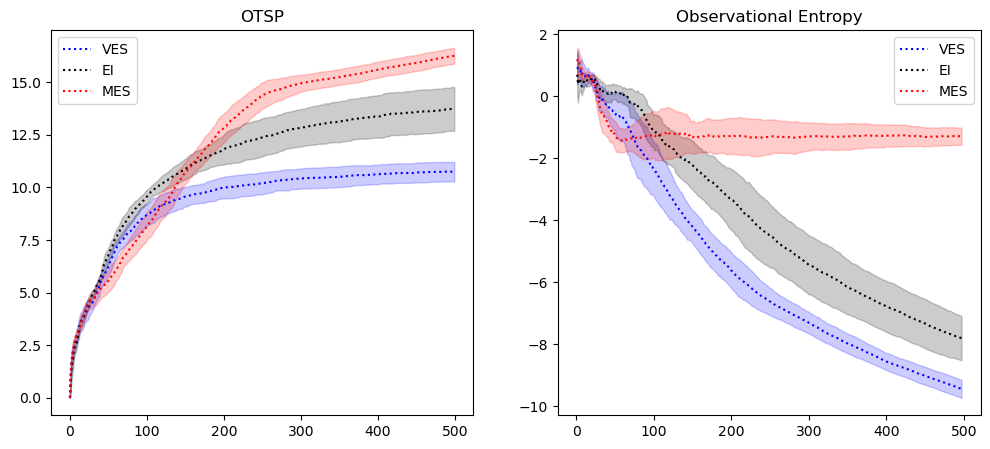

In [13]:
min_len = 500

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

x_dict = {
    'VES': ves_x,
    'EI': ei_x,
    'MES': mes_x,
}

colors = {
    'VES': 'blue',
    'EI': 'black',
    'MES': 'red',
}

for k, x_lst in x_dict.items():

    exp_x_disp = [exploration_tsp(x[:min_len]) for x in x_lst]
    exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
    exp_mean_disp = np.mean(exp_x_disp, axis=0)
    exp_std_disp = np.std(exp_x_disp, axis=0)

    axs[0].plot(exp_mean_disp, label=k, color=colors[k], linestyle=':')
    axs[0].fill_between(np.arange(len(exp_mean_disp)), exp_mean_disp-exp_std_disp, exp_mean_disp+exp_std_disp, alpha=0.2, color=colors[k])
    axs[0].legend()
    axs[0].set_title('OTSP')

    exp_x_entp = [exploration_entropy(x[:min_len]) for x in x_lst]
    exp_x_entp = np.stack(exp_x_entp)
    exp_mean_entp = np.mean(exp_x_entp, axis=0)
    exp_std_entp = np.std(exp_x_entp, axis=0)

    axs[1].plot(exp_mean_entp, label=k, color=colors[k], linestyle=':')
    axs[1].fill_between(np.arange(len(exp_mean_entp)), exp_mean_entp-exp_std_entp, exp_mean_entp+exp_std_entp, alpha=0.2, color=colors[k])
    axs[1].legend()
    axs[1].set_title('Observational Entropy')


In [4]:
# Global parameters
BOUNDS = torch.zeros(2,2)
BOUNDS[:, 1] = torch.ones(2)
NUM_TRIALS = 10
NUM_ITER = 100
NUM_PATHS = 64
# 2D discretization parameters
nx = 101
ny = 101
# Create meshgrid for 2D discretization
x = np.linspace(BOUNDS[0, 0].item(), BOUNDS[0, 1].item(), nx)
y = np.linspace(BOUNDS[1, 0].item(), BOUNDS[1, 1].item(), ny)
X, Y = np.meshgrid(x, y)
Z = np.array([[objective(torch.tensor([xi, yi])) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

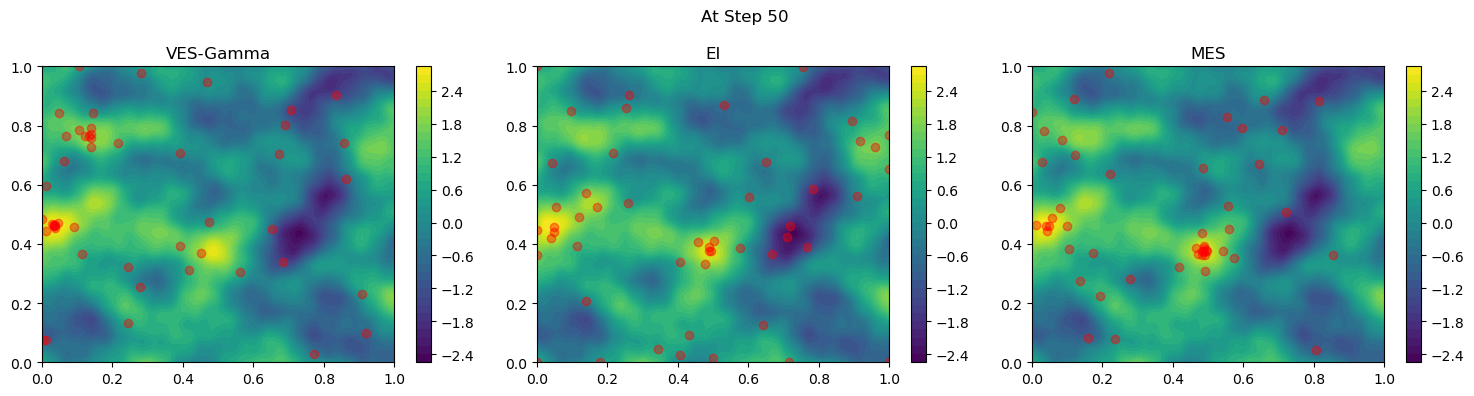

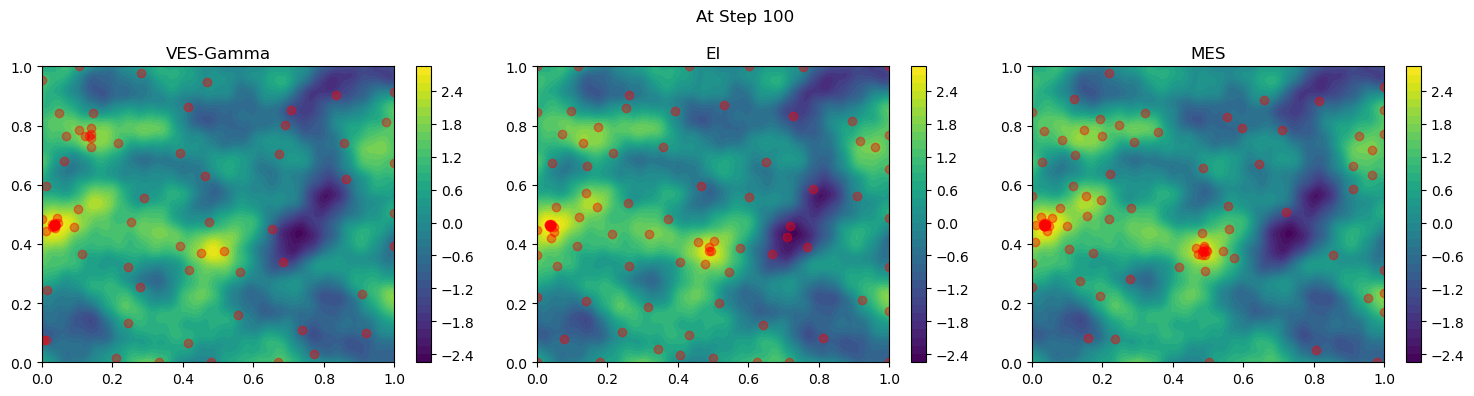

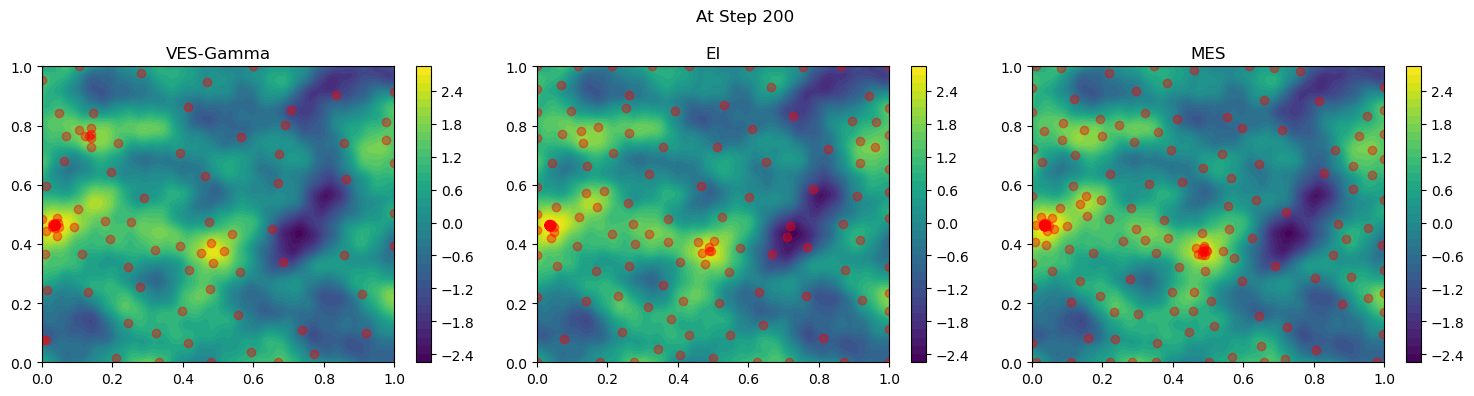

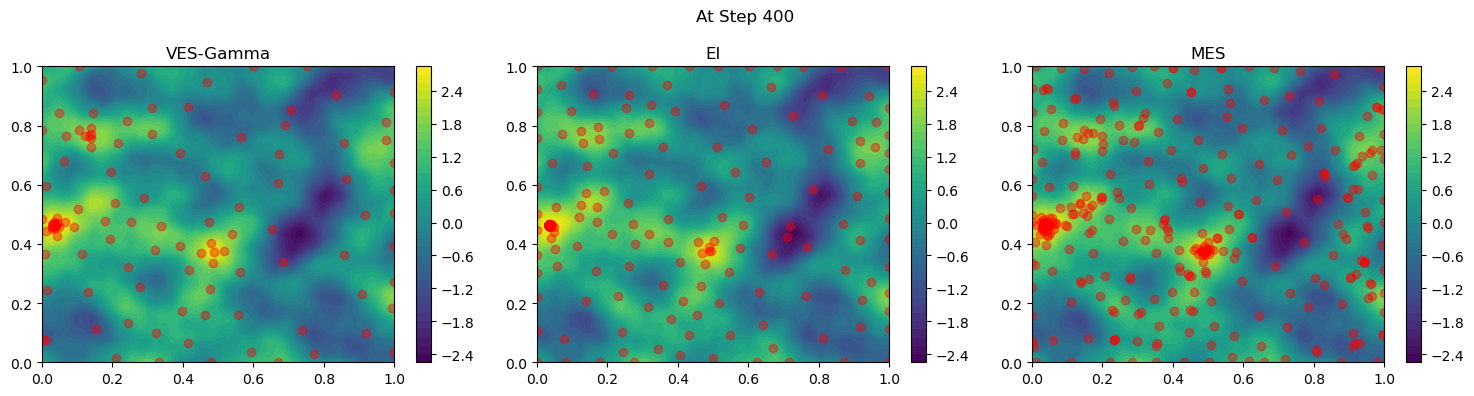

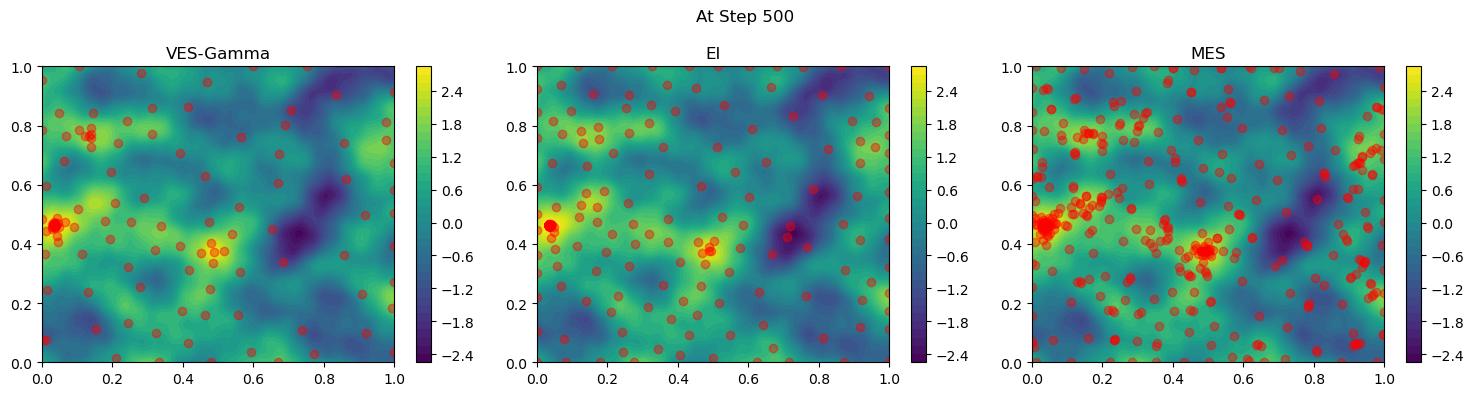

In [5]:
M_lst = [50, 100, 150, 200]
for M in M_lst:
    # Create three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'At Step {M}')
    idx = 0
    # Plot 1: 
    cp1 = axs[0].contourf(X, Y, Z, levels=50, cmap='viridis')
    fig.colorbar(cp1, ax=axs[0])
    axs[0].scatter(ves_x[idx][:M, 0], ves_x[idx][:M, 1], color='red', alpha=0.4)
    axs[0].set_title('VES-Gamma')

    # Plot 2: 
    cp2 = axs[1].contourf(X, Y, Z, levels=50, cmap='viridis')
    fig.colorbar(cp2, ax=axs[1])
    axs[1].scatter(ei_x[idx][:M, 0], ei_x[idx][:M, 1], color='red', alpha=0.4)
    axs[1].set_title('EI')

    # Plot 3: 
    cp3 = axs[2].contourf(X, Y, Z, levels=50, cmap='viridis')
    fig.colorbar(cp3, ax=axs[2])
    axs[2].scatter(mes_x[idx][:M, 0], mes_x[idx][:M, 1], color='red', alpha=0.4)
    axs[2].set_title('MES')

    # Adjust layout
    plt.tight_layout()
plt.show()